## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [8]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt
import IPython.display as ipd

import numpy as np
import torch
import librosa

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence

%matplotlib inline

/home/chrizandr/tacotron2/venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/chrizandr/tacotron2/venv/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/chrizandr/tacotron2/venv/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/chrizandr/tacotron2/venv/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 499, in start
    s

In [9]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [10]:
hparams = create_hparams("distributed_run=False,mask_padding=False")
hparams.sampling_rate = 22050
hparams.filter_length = 1024
hparams.hop_length = 256
hparams.win_length = 1024

INFO:tensorflow:Parsing command line hparams: distributed_run=False,mask_padding=False


#### Load model from checkpoint

In [11]:
checkpoint_path = "/home/chrizandr/tacotron2/tts_out/checkpoint_357500"
model = load_model(hparams)
try:
    model = model.module
except:
    pass
model.load_state_dict({k.replace('module.',''):v for k,v in torch.load(checkpoint_path)['state_dict'].items()})
_ = model.eval()

taco_stft = TacotronSTFT(
    hparams.filter_length, hparams.hop_length, hparams.win_length, 
    sampling_rate=hparams.sampling_rate)

#### Prepare text input

In [88]:
text = "[ ]  AERONAUTICS"
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

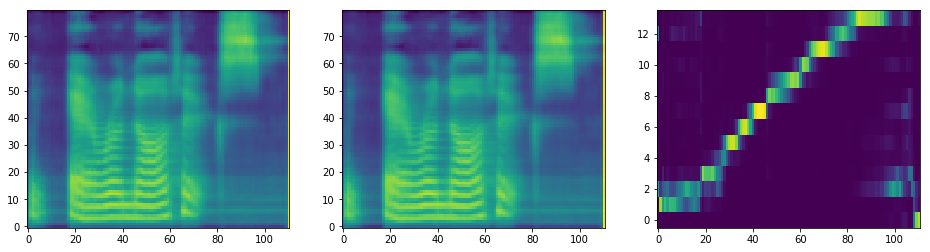

In [89]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))

#### Load TacotronSTFT and convert mel-spectrogram to spectrogram

In [90]:

mel_decompress = taco_stft.spectral_de_normalize(mel_outputs_postnet)
mel_decompress = mel_decompress.transpose(1, 2).data.cpu()
spec_from_mel_scaling = 1000
spec_from_mel = torch.mm(mel_decompress[0], taco_stft.mel_basis)
spec_from_mel = spec_from_mel.transpose(0, 1).unsqueeze(0)
spec_from_mel = spec_from_mel * spec_from_mel_scaling

#### Synthesize audio from spectrogram using the Griffin-Lim algorithm

In [91]:
waveform = griffin_lim(torch.autograd.Variable(spec_from_mel[:, :, :-1]), 
                       taco_stft.stft_fn, 120)

print(type(waveform))

<class 'torch.Tensor'>


In [92]:
librosa.output.write_wav('out_0.wav', waveform[0].data.cpu().numpy(), 22050)
ipd.Audio(waveform[0].data.cpu().numpy(), rate=hparams.sampling_rate) 